While in development, MLA is not available via pip, so to import it, you need to add the location of the repository on GitHub to the python path.

Run this once, then restart the kernel

In [13]:
import sys
!{sys.executable} -m pip uninstall -y mla-thejevans
!{sys.executable} -m pip install numba git+https://github.com/thejevans/mla.git@flare-stack

Found existing installation: mla-thejevans 0.0.1
Uninstalling mla-thejevans-0.0.1:
  Successfully uninstalled mla-thejevans-0.0.1
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/thejevans/mla.git (to revision flare-stack) to /tmp/pip-req-build-6ca69q8v
  Running command git clone --filter=blob:none --quiet https://github.com/thejevans/mla.git /tmp/pip-req-build-6ca69q8v
  Running command git checkout -b flare-stack --track origin/flare-stack
  Switched to a new branch 'flare-stack'
  Branch 'flare-stack' set up to track remote branch 'flare-stack' from 'origin'.
  Resolved https://github.com/thejevans/mla.git to commit d967ce03f3238b476a8b70ec73523879c03fd690
  Preparing metadata (setup.py) ... done
  Created wheel for mla-thejevans: filename=mla_thejevans-0.0.1-py3-none-any.whl size=41082 sha256=5c3e897e895fe150392dc8b5ce829f1827a89a0c2dadb5b38a187fe9574f2441
  Stored in directory: /tmp/pip-ephem-wheel-cache-71s9_vj0/wheels/8e

In [1]:
import json

import matplotlib.pyplot as plt
import mla
import numpy as np

For this example, we'll just use one year of data

In [2]:
# CONSTANTS
DATA_DIR = '/data/mjlarson/version-004-p01/'
DATA_FILE_NAME = 'IC86_2012_exp.npy'
SIM_FILE_NAME = 'IC86_2016_MC.npy'

DATA_FILE = DATA_DIR + '/' + DATA_FILE_NAME
SIM_FILE = DATA_DIR + '/' + SIM_FILE_NAME
GRL_FILE = DATA_DIR + '/GRL/' + DATA_FILE_NAME

Let's load in our event data and see what it looks like

In [3]:
data_np = np.load(DATA_FILE)
print(f'{data_np.dtype.names = }\n\n{len(data_np) = }\n\n{data_np}\n\n{80 * "-"}\n')

sim_np = np.load(SIM_FILE)
print(f'{sim_np.dtype.names = }\n\n{len(sim_np) = }\n\n{80 * "-"}\n')

grl = np.load(GRL_FILE)
print(f'{grl.dtype.names = }\n\n{grl}')

data_np.dtype.names = ('run', 'event', 'subevent', 'ra', 'dec', 'azi', 'zen', 'time', 'logE', 'angErr')

len(data_np) = 116897

[(120028,  839634, 0, 4.64491964, -0.99387321, 3.35139177, 0.57682579, 56043.42668248, 4.86349265, 0.00260412)
 (120028, 1578865, 0, 3.01202852,  0.02389263, 5.0057937 , 1.59350929, 56043.42980643, 3.07246761, 0.00635448)
 (120028, 2116382, 0, 2.75532733,  0.14988575, 5.27674119, 1.71960492, 56043.43207568, 3.46363712, 0.01092795)
 ...
 (122275, 8273253, 0, 2.12753894,  0.01541207, 5.86127356, 1.58555405, 56414.40950511, 3.35575262, 0.00471234)
 (122275, 8753212, 0, 5.02908201,  1.10426143, 2.97497898, 2.67531515, 56414.41155752, 3.55747872, 0.01335417)
 (122275, 9211233, 0, 4.55031389, -0.57089879, 3.46286981, 0.99965481, 56414.4135139 , 4.79049354, 0.0091625 )]

--------------------------------------------------------------------------------

sim_np.dtype.names = ('run', 'event', 'subevent', 'ra', 'dec', 'azi', 'zen', 'time', 'logE', 'angErr', 'trueRa', 'tru

`i3mla` is a software package that takes the data, sim, and GRL, and allows you to perform different analyses. For this example, we'll be doing a time-integrated point-source search.

The workflow for `i3mla` is:
1. build components for analysis file for your analysis type
1. compile the components into an analysis file
1. run randomized trials to calculate our sensitivity for your analysis
1. compare the real data to randomized trials to see if what we see is significant

We will be building a `SingleSourceLLHAnalysis` which needs:
- a `test_statistic_factory` to tell it what your likelihood looks like
- an `injector` to tell it how to build randomized trials of events
- a `source` to tell it where you expect signal events to come from
- a `trial_generator` to actually generate randomized trials

Before we go about building these components, there are a lot of possible configuration parameters that go into an analysis like this. `i3mla` has a way to generate a configuration dictionary so that you can start with reasonable defaults and edit as you like. Our first order of business will be to generate the configuaration for our analysis components.

In [4]:
config = mla.generate_default_config([
    (mla.NuSourcesDataHandler, 'data handler'),
    (mla.SplineMapEnergyTermFactory, 'energy term'),
    (mla.SpatialTermFactory, 'spatial term'),
    (mla.PointSource, 'PSO J0309+27'),
    (mla.LLHTestStatisticFactory, 'test statistic'),
    (mla.SingleSourceTrialGenerator, 'trial generator'),
])
print(json.dumps(config, indent=4))

{
    "data handler": {
        "class": "NuSourcesDataHandler",
        "args": {
            "norm_energy": 1000.0,
            "assumed_gamma": -2,
            "dec_cut_loc": null,
            "dec_band": null,
            "sin_dec_bins": 30,
            "dec_spline_kwargs": {
                "bbox": [
                    -1,
                    1
                ],
                "s": 1.5e-05,
                "ext": 3
            }
        }
    },
    "energy term": {
        "class": "SplineMapEnergyTermFactory",
        "args": {
            "name": "SoBTerm",
            "init_gamma": -2,
            "sin_dec_bins": 50,
            "log_energy_bins": 50,
            "log_energy_bounds": [
                1,
                8
            ],
            "gamma_bins": 50,
            "gamma_bounds": [
                -3.75,
                -0.5
            ],
            "norm_bghist_by_dec_band": false,
            "sob_spline_kwargs": {
                "k": 3,
                "

As you can see, there are quite a few options. A few need to be changed before we move forward, but the majority can be left alone.

In [5]:
#  PSO J0309+27 - the most distant known blazar...z=6.1
# https://en.wikipedia.org/wiki/PSO_J030947.49%2B271757.31
#RA 03h 09m 47.49s
#DEC+27° 17′ 57.31″

source_dec = mla.dec_to_rad(1, 27, 17, 57.31)

config['PSO J0309+27']['args']['ra'] = mla.ra_to_rad(3, 9, 47.49)
config['PSO J0309+27']['args']['dec'] = source_dec

# To speed up computation, let's cut away simulation events that are more than
# 2 degrees from our source declination
config['data handler']['args']['dec_band'] = np.deg2rad(2)
config['data handler']['args']['dec_cut_loc'] = source_dec

`i3mla` wants the event data in it's own internal format, so lets convert it

In [6]:
data = mla.Events.from_nusources_events(data_np)
sim = mla.SimEvents.from_nusources_events(sim_np)

/home/jevans96/.local/lib/python3.10/site-packages/mla/events.py:74: UserWarning: Dtype of 'run' in input structured array is int64. Converting to uint64.
  warnings.warn(''.join([
/home/jevans96/.local/lib/python3.10/site-packages/mla/events.py:74: UserWarning: Dtype of 'event' in input structured array is int64. Converting to uint64.
  warnings.warn(''.join([
/home/jevans96/.local/lib/python3.10/site-packages/mla/events.py:74: UserWarning: Dtype of 'subevent' in input structured array is int64. Converting to uint64.
  warnings.warn(''.join([


Now, let's use the configuration to build the analysis components. We'll start with the `PointSource`, and `NuSourcesDataHandler` because they only depend on the configuration and the data files. From the `NuSourcesDataHandler` object we can build our `injector`. 

In [7]:
source = mla.PointSource(**config['PSO J0309+27']['args'])

data_handler = mla.NuSourcesDataHandler(
    **config['data handler']['args'], sim=sim, data=data, grl=grl)

injector = data_handler.build_injector()

Next, we can build our likelihood by first building our likelihood terms: `SplineMapEnergyTermFactory` and `SpatialTermFactory`, then use them to build our likelihood object `LLHTestStatisticFactory`.

In [8]:
spline_map_energy_term_factory = mla.SplineMapEnergyTermFactory(
    **config['energy term']['args'], data_handler=data_handler)

spatial_term_factory = mla.SpatialTermFactory(
    **config['spatial term']['args'], injector=injector, source=source)

test_statistic_factory = mla.LLHTestStatisticFactory(
    **config['test statistic']['args'],
    sob_term_factories=[spline_map_energy_term_factory, spatial_term_factory],
)

Finally, we can make our `SingleSourceTrialGenerator` and put it all together in a `SingleSourceLLHAnalysis` object. This object can be saved via `pickle` to use later if needed and it has everything we need to do our analysis going forward.

In [9]:
trial_generator = mla.SingleSourceTrialGenerator(
    **config['trial generator']['args'], injector=injector, source=source)

analysis = mla.SingleSourceLLHAnalysis(
    injector=injector,
    source=source,
    test_statistic_factory=test_statistic_factory,
    trial_generator=trial_generator,
)

Now that you have an `Analysis`, you can start on your analysis! The most basic thing you can do is produce a randomized trial of events from your `trial_generator`. After that, you can minimize the test statistic (maximize the likelihood) for that trial, so let's do that.

len(trial) = 116509
Events(_ints=array([[ 120028,  120028,  120028, ...,   21002,   21220,   21002],
       [ 839634, 1578865, 1578865, ...,   28978,      68,   36191],
       [      0,       0,       0, ...,       0,       0,       0]],
      dtype=uint64), _floats=array([[ 5.60479679e-01,  3.49430359e+00,  2.60445388e+00, ...,
         8.24996259e-01,  8.33590537e-01,  8.24660044e-01],
       [-9.93873210e-01,  2.38926296e-02,  2.38926296e-02, ...,
         4.76999205e-01,  5.08626192e-01,  4.80345501e-01],
       [ 3.35139177e+00,  5.00579370e+00,  5.00579370e+00, ...,
         4.68005386e+00,  3.38822011e+00,  3.57108261e+00],
       ...,
       [ 4.86349265e+00,  3.07246761e+00,  3.07246761e+00, ...,
         3.81144148e+00,  3.22467613e+00,  3.53659895e+00],
       [ 2.60411954e-03,  6.35447559e-03,  6.35447559e-03, ...,
         2.32716685e-03,  5.80782718e-03,  3.40606348e-03],
       [-8.38144893e-01,  2.38903565e-02,  2.38903565e-02, ...,
         4.59115411e-01,  4.86977804e

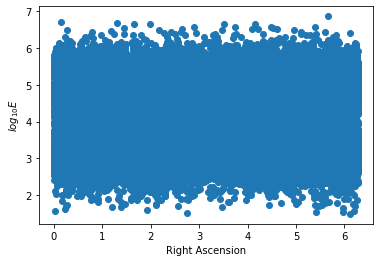

params = Params(value_array=array([ 0., -2.]), key_idx_map={'ns': 0, 'gamma': 1}, bounds={'ns': (0, inf), 'gamma': (-3.75, -0.5)})


In [10]:
trial = analysis.produce_trial(n_signal=np.sqrt(10) * 1e-15)

print(f'{len(trial) = }\n{trial}')

# Plot the trial events
plt.scatter(trial.ra, trial.logE)
plt.xlabel('Right Ascension')
plt.ylabel(r'$log_{10}E$')
plt.show()

# to minimize the test statistic, you need to generate a parameter object
# this will be used by the test statistic object to calculate the likelihood
# and by the minimizer to tweak and find the minimum
params = analysis.generate_params()
print(f'{params = }')

This next bit you wouldn't normally do, but lets evaluate the test statistic without any minimizing and take a look at the signal-over-background histogram of the events in the trial.

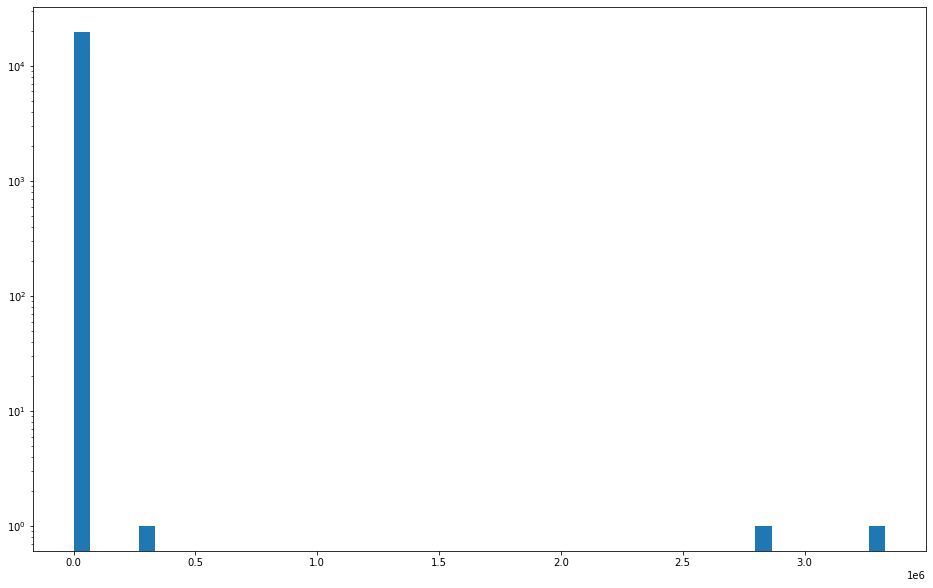

In [11]:
test_statistic = analysis.test_statistic_factory(params, trial)

plt.figure(figsize=(16,10))
plt.hist(test_statistic._calculate_sob(),bins=50)
plt.yscale('log')

Now lets use our analysis object to minimize the test statistic for the trial, fitting the `gamma` parameter.

In [12]:
best_fit = analysis.minimize_trial(trial, params, ['gamma'])
print(json.dumps(best_fit, indent=4))

{
    "ts": -19.80870828221806,
    "ns": 5.312442177101373,
    "gamma": -1.9544601050562307
}


Now, lets use `produce_and_minimize` to do the same with 10 trials:

In [13]:
results = [
    analysis.produce_and_minimize(analysis.generate_params(), 'gamma', 1e-15)
    for _ in range(10)
]
print(json.dumps(results, indent=4))

[
    {
        "ts": -9.116667891866168,
        "ns": 12.784496491821063,
        "gamma": -3.75
    },
    {
        "ts": -5.547306791323209,
        "ns": 5.169308405954777,
        "gamma": -2.1066483710360813
    },
    {
        "ts": -0.0,
        "ns": 0.0,
        "gamma": -3.75
    },
    {
        "ts": -13.271874153607957,
        "ns": 2.50703875065678,
        "gamma": -0.5
    },
    {
        "ts": -0.0,
        "ns": 0.0,
        "gamma": -3.75
    },
    {
        "ts": -10.01277836889544,
        "ns": 1.3615919143172992,
        "gamma": -0.5
    },
    {
        "ts": -7.651800205782392,
        "ns": 1.2242380351993645,
        "gamma": -0.5
    },
    {
        "ts": -8.045350190908408,
        "ns": 1.3129157942825678,
        "gamma": -0.5
    },
    {
        "ts": -4.696030546626613,
        "ns": 10.031262297283147,
        "gamma": -2.9046584223271683
    },
    {
        "ts": -1.8792747250836097,
        "ns": 6.887720856979629,
        "gamma": -3.75
 

In [14]:
neg_ts = [-trial['ts'] for trial in results]
ns = [trial['ns'] for trial in results]
print(f'{neg_ts = }\n\n{ns = }\n\n{np.mean(neg_ts) = }, {np.mean(ns) = }')

neg_ts = [9.116667891866168, 5.547306791323209, 0.0, 13.271874153607957, 0.0, 10.01277836889544, 7.651800205782392, 8.045350190908408, 4.696030546626613, 1.8792747250836097]

ns = [12.784496491821063, 5.169308405954777, 0.0, 2.50703875065678, 0.0, 1.3615919143172992, 1.2242380351993645, 1.3129157942825678, 10.031262297283147, 6.887720856979629]

np.mean(neg_ts) = 6.02210828740938, np.mean(ns) = 4.127857254649462


In [15]:
# Produce and minimize 100 trials, then plot the ts distribution

print("Producing 100 trials n_inj = ~50")
best_fit_arr_50 = [
    analysis.produce_and_minimize(analysis.generate_params(), 'gamma', 3e-14)
    for _ in range(100)
]

print("Producing 100 trials n_inj = ~20")
best_fit_20 = [
    analysis.produce_and_minimize(analysis.generate_params(), 'gamma', 1e-14)
    for _ in range(100)
]

print("Producing 100 trials n_inj = ~5")
best_fit_5 = [
    analysis.produce_and_minimize(analysis.generate_params(), 'gamma', 2e-15)
    for _ in range(100)
]

print("Producing 100 trials n_inj = ~1")
best_fit_1 = [
    analysis.produce_and_minimize(analysis.generate_params(), 'gamma', 1e-16)
    for _ in range(100)
]

print("Producing 500 bg only trials")
best_fit_bg = [
    analysis.produce_and_minimize(analysis.generate_params(), 'gamma', 0)
    for _ in range(500)
]

Producing 100 trials n_inj = ~50
Producing 100 trials n_inj = ~20
Producing 100 trials n_inj = ~5
Producing 100 trials n_inj = ~1
Producing 500 bg only trials


In [16]:
ts_bg, ns_bg = zip(*[(-trial['ts'], trial['ns']) for trial in best_fit_bg])
ts_50, ns_50 = zip(*[(-trial['ts'], trial['ns']) for trial in best_fit_arr_50])
ts_20, ns_20 = zip(*[(-trial['ts'], trial['ns']) for trial in best_fit_20])
ts_5, ns_5 = zip(*[(-trial['ts'], trial['ns']) for trial in best_fit_5])
ts_1, ns_1 = zip(*[(-trial['ts'], trial['ns']) for trial in best_fit_1])

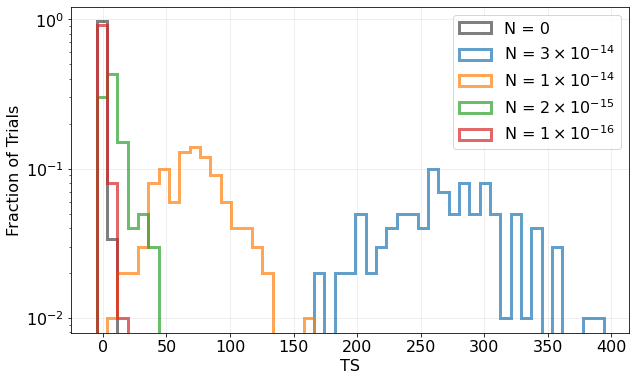

In [17]:
# Plot the signal and background LLHs
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(-5, 394, 50)

ax.hist(ts_bg,
        bins = bins,
        weights = np.ones_like(ts_bg)/len(ts_bg),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0',
       )

ax.hist(ts_50,
        bins = bins,
        weights = np.ones_like(ts_50)/len(ts_50),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $3 \times 10^{-14}$')

ax.hist(ts_20,
        bins = bins,
        weights = np.ones_like(ts_20)/len(ts_20),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $1 \times 10^{-14}$')

ax.hist(ts_5,
        bins = bins,
        weights = np.ones_like(ts_5)/len(ts_5),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $2 \times 10^{-15}$')

ax.hist(ts_1,
        bins = bins,
        weights = np.ones_like(ts_1)/len(ts_1),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $1 \times 10^{-16}$')

ax.legend(loc='upper right', fontsize=16,)
plt.yscale('log')
ax.grid(alpha=0.25)
#ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)

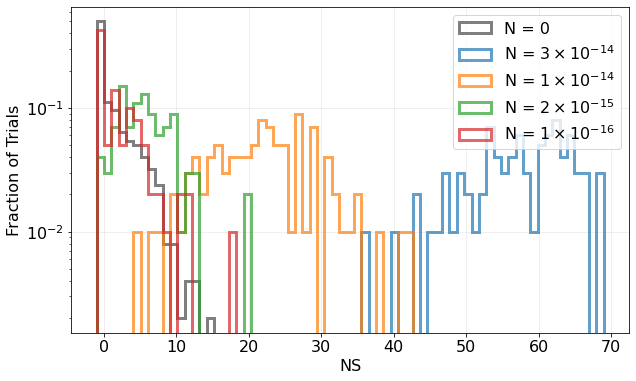

In [18]:
# Plot the best fit ns
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(-1, 69, 70)

ax.hist(ns_bg,
        bins = bins,
        weights = np.ones_like(ns_bg)/len(ns_bg),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0',
       )

ax.hist(ns_50,
        bins = bins,
        weights = np.ones_like(ns_50)/len(ns_50),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $3 \times 10^{-14}$')

ax.hist(ns_20,
        bins = bins,
        weights = np.ones_like(ns_20)/len(ns_20),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $1 \times 10^{-14}$')

ax.hist(ns_5,
        bins = bins,
        weights = np.ones_like(ns_5)/len(ns_5),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $2 \times 10^{-15}$')
ax.hist(ns_1,
        bins = bins,
        weights = np.ones_like(ns_1)/len(ns_1),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $1 \times 10^{-16}$')

ax.legend(loc='upper right', fontsize=16,)
plt.yscale('log')
ax.grid(alpha=0.25)
#ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("NS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)


Starting to setup an analysis
* background only TS distributions.
* signal injections (flux vs. n_injected above)
* find point where you make "discovery" and are "sensitive"
* then look at real data.  What is your TS, where does it land relative to these distributions?  Did you discovery anything?

In [19]:
# calculate the unblinded TS
true_res = analysis.minimize_trial(data, analysis.generate_params(), ['gamma'])
print(json.dumps(true_res, indent=4))

{
    "ts": -0.0,
    "ns": 0.0,
    "gamma": -3.75
}


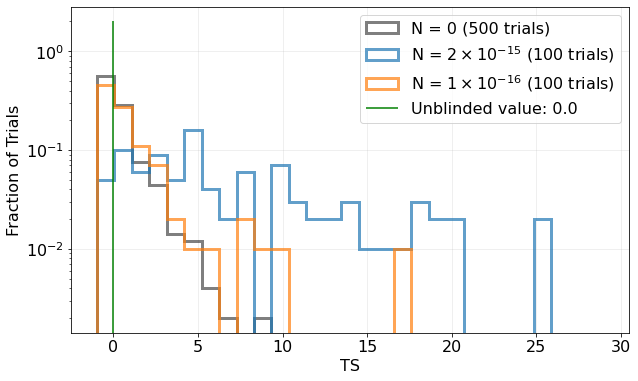

In [20]:
# Plot the unblinded TS
fig, ax = plt.subplots(figsize=(10,6))
bins = np.linspace(-1, 29, 30)

ax.hist(ts_bg,
        bins = bins,
        weights = np.ones_like(ts_bg)/len(ts_bg),
        histtype = 'step',
        color = 'k',
        linewidth = 3,
        alpha=0.5,
        label = r'N = 0 (500 trials)',
       )

ax.hist(ts_5,
        bins = bins,
        weights = np.ones_like(ts_5)/len(ts_5),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $2 \times 10^{-15}$ (100 trials)')

ax.hist(ts_1,
        bins = bins,
        weights = np.ones_like(ts_1)/len(ts_1),
        histtype = 'step',
        linewidth = 3,
        alpha = 0.7,
        label = r'N = $1 \times 10^{-16}$ (100 trials)')

ax.vlines(-true_res['ts'], 0, 2.0, label = r'Unblinded value: {}'.format(round(-true_res['ts'],2)),colors=['green'])
ax.legend(loc='upper right', fontsize=16,)
plt.yscale('log')
ax.grid(alpha=0.25)
#ax.set_xlim(bins.min(), bins.max())
ax.set_xlabel("TS", fontsize=16)
ax.set_ylabel("Fraction of Trials", fontsize=16)
ax.tick_params(which='both', labelsize=16)